In [ ]:
%cd /content/drive/MyDrive/Gehc equip

[Errno 2] No such file or directory: '/content/drive/MyDrive/Gehc equip'
/content


In [ ]:
%cd /content/drive/MyDrive/Gehc equip/yolov5

/content/drive/MyDrive/Gehc equip/yolov5


In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r requirements.txt

In [ ]:
import torch
from IPython.display import Image 
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd
from os.path import join
import pickle
import glob

random.seed(108)

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"ultrasonography": 0,
                           "syringpump": 1,
                           "ventilator": 2,}

dirs = ['annotations']
classes = ['ultrasonography', 'syringpump', 'ventilator']

In [ ]:
def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.png'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

cwd = getcwd()

for dir_path in dirs:
    full_dir_path = cwd + '/' + dir_path
    output_path = full_dir_path +'/yolo/'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')

    for image_path in image_paths:
        list_file.write(image_path + '\n')
        convert_annotation(full_dir_path, output_path, image_path)
    list_file.close()

    print("Finished processing: " + dir_path)

Finished processing: annotations


In [ ]:
annotations = [os.path.join('annotations/yolo', x) for x in os.listdir('annotations/yolo') if x[-3:] == "txt"]

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()


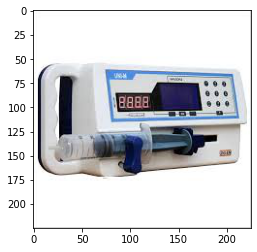

In [ ]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations/yolo", "annotations").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


In [ ]:
# Read images and annotations
images = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "png"]
annotations = [os.path.join('annotations/yolo', x) for x in os.listdir('annotations/yolo') if x[-3:] == "txt"]

# annotations = [os.path.join('annotations/yolo', x) for x in os.listdir('annotations/yolo') if x[-3:] == "txt"]

images.sort()
annotations.sort()  

In [ ]:
annotations

In [ ]:
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            raise

# !os.mkdir 

# Move the splits into their folders
move_files_to_folder(train_images, 'datasets/images/Train')
move_files_to_folder(val_images, 'datasets/images/Val')
move_files_to_folder(test_images, 'datasets/images/Test')
move_files_to_folder(train_annotations, 'datasets/labels/Train')
move_files_to_folder(val_annotations, 'datasets/labels/Val')
move_files_to_folder(test_annotations, 'datasets/labels/Test')

In [ ]:
train_images[0]

'annotations/equip193.png'

In [ ]:
train_annotations

In [ ]:
move_files_to_folder(train_images, 'datasets/images/Train')

In [ ]:
for f in train_images:
  shutil.copy(f, 'datasets/images')

In [ ]:
%cd /content/drive/MyDrive/Gehc equip/yolov5


/content/drive/MyDrive/Gehc equip/yolov5


In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data medeq.yaml --weights yolov5s.pt --workers 24 --name med_equip


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=medeq.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=med_equip, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 2021-12-1 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv

In [ ]:
!python detect.py --source ../datasets/images/test/ --weights runs/train/med_equip10//weights/best.pt --conf 0.25 --name med_equip


detect: weights=['runs/train/med_equip10//weights/best.pt'], source=../datasets/images/test/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=med_equip, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2021-12-1 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/21 /content/drive/My Drive/Gehc equip/datasets/images/test/equip112.png: 640x640 1 ultrasonography, Done. (0.034s)
image 2/21 /content/drive/My Drive/Gehc equip/datasets/images/test/equip122.png: 640x544 Done. (0.033s)
image 3/21 /content/drive/My Drive/Gehc equip/datasets/images/test/equip123.png: 640x352 1 ventilator, Done. (0.030s)
image 4/21 /content/drive/My Drive/Gehc 

In [ ]:

import os

def main():
    folder = "../Dataset/blur/images"
    for count, filename in enumerate(os.listdir(folder)):
        dst = f"equip{str(count)}.jpg"
        src =f"{folder}/{filename}"
        dst =f"{folder}/{dst}"

        os.rename(src, dst)

    
# Driver Code
if __name__ == '__main__':
    main()

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split


# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images') if x[-3:] == "jpg"]
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

# annotations = [os.path.join('annotations/yolo', x) for x in os.listdir('annotations/yolo') if x[-3:] == "txt"]

images.sort()
annotations.sort() 

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.4, random_state = 1)

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            raise


# Move the splits into their folders
move_files_to_folder(train_images, 'datasets/images/Train')
move_files_to_folder(val_images, 'datasets/images/Val')
move_files_to_folder(test_images, 'datasets/images/Test')
move_files_to_folder(train_annotations, 'datasets/labels/Train')
move_files_to_folder(val_annotations, 'datasets/labels/Val')
move_files_to_folder(test_annotations, 'datasets/labels/Test')